### <center>Chestnut Bur Detection and Segmentation using MaskRCNN in PyTorch</center>

In [1]:
%matplotlib inline

import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, Subset, DataLoader
import torchvision
from torchvision import transforms as _transforms, tv_tensors
import torchvision.transforms.v2 as T
from torchvision.transforms import functional as F
import json
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from pathlib import Path
import gc
import os
from PIL import Image, ImageDraw, ImageOps

from segmentation_pytorch import engine

In [2]:
gc.collect()
torch.cuda.empty_cache()

##### <center> Load the image and annotation data </center>

In [3]:
# load annotations from json file here: "C:\Users\exx\Downloads\Route 9 Orchard 3.v1-test_dataset.coco-segmentation\train\_annotations.coco.json"
annos = json.load(open("C:/Users/exx/Deep Learning/Chestnut_Bur_Instance_Segmentation/route9_orchard3/data/_annotations.coco.json"))

In [4]:
# convert the annos dict to a df
annos_df = pd.DataFrame(annos["annotations"])
df = pd.DataFrame()
df["tree_id"] = annos_df["image_id"].apply(lambda x: annos["images"][x]["file_name"].split("_")[0])
df["file_name"] = annos_df["image_id"].apply(lambda x: annos["images"][x]["file_name"])
df["file_name"] = df["file_name"].apply(lambda x: x.split("_")[0] + ".png")
categories = [cat["name"] for cat in annos["categories"]]
df["category_name"] = annos_df["category_id"].apply(lambda x: categories[x])
df["bbox"] = annos_df["bbox"].apply(lambda x: torch.tensor(x))
df["area"] = annos_df["area"].apply(lambda x: torch.tensor(x))
df["segmentation"] = annos_df["segmentation"].apply(lambda x: torch.tensor(x))
df["iscrowd"] = annos_df["iscrowd"]

# Filter df to remove treeIds not reviewed. 
reviewed_trees = [
    14, 44, 51, 60, 79, 91, 92, 117, 118, 146, 152, 171, 
    172, 210, 272, 276, 280, 286, 304, 309, 320, 329, 
    366, 369, 371, 392, 394, 405
]

df = df[df["tree_id"].isin([str(tree_id) for tree_id in reviewed_trees])]

In [5]:
image_dir = "C:/Users/exx/Deep Learning/Chestnut_Bur_Instance_Segmentation/route9_orchard3/data/images"
image_names = df["file_name"].unique()
mask_dir = "C:/Users/exx/Deep Learning/Chestnut_Bur_Instance_Segmentation/route9_orchard3/data/masks"

In [6]:
# # plot each image with its canopy polygon mask and chestnut polygon masks

# os.makedirs("C:/Users/exx/Deep Learning/Chestnut_Bur_Instance_Segmentation/route9_orchard3/annotated_images", exist_ok=True)

# for i, tree_id in enumerate(df["tree_id"].unique()):
#     image_file = Path(image_dir) / df[df["tree_id"] == tree_id]["file_name"].values[0]
#     image = Image.open(image_file)
#     # get image width and height
#     width, height = image.size

#     # print(f"tree {tree_id} has a width of {width} and height of {height} pixels")

#     canopy_poly = df[(df["tree_id"] == tree_id) & (df["category_name"] == "Canopy")]["segmentation"].values
#     bur_poly = df[(df["tree_id"] == tree_id) & (df["category_name"] == "Chestnut-burr")]["segmentation"].values

#     canopy_poly = [np.array(poly[0]).reshape(-1, 2).astype(np.int32) for poly in canopy_poly]
#     bur_poly = [np.array(poly[0]).reshape(-1, 2).astype(np.int32) for poly in bur_poly]

#     # Create a drawing context
#     draw = ImageDraw.Draw(image)
    
#     for poly in canopy_poly:
#         draw.polygon([tuple(point) for point in poly], outline="purple", width=2)
#     for poly in bur_poly:
#         draw.polygon([tuple(point) for point in poly], outline="red")

#     # Save the image
#     image.save(f"C:/Users/exx/Deep Learning/Chestnut_Bur_Instance_Segmentation/route9_orchard3/annotated_images/{tree_id}_annotated.png", format='PNG')

##### <center> Pre-process and transform image and annotation data </center>

##### Adapted from: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#an-instance-segmentation-model-for-pennfudan-dataset

In [7]:
def mask_fill(mask, polys, color):
    from cv2 import fillPoly
    for poly in polys:
        fillPoly(mask, [poly], color)
    return mask

In [8]:
# class ChestnutBurSegmentation(Dataset):
#     """Custom Dataset for Chestnut Bur Segmentation in UAV Images"""

#     def __init__(self, image_dir, df, transform=None, tile_size=512):
#         self.image_dir = image_dir
#         self.df = df
#         self.transform = transform
#         self.tile_size = tile_size
#         self.tiles = self.create_tile_indices()

#     def create_tile_indices(self):
#         tile_indices = []
#         for tree_id in self.df["tree_id"].unique():
#             canopy_poly = self.df[(self.df["tree_id"] == tree_id) & (self.df["category_name"] == "Canopy")]["segmentation"].values
#             canopy_poly = [np.array(poly[0]).reshape(-1, 2).astype(np.int32) for poly in canopy_poly]

#             # get canopy_bbox coords [xmin, ymin, xmax, ymax]
#             xmin, ymin, xmax, ymax = min([poly[:, 0].min() for poly in canopy_poly]), min([poly[:, 1].min() for poly in canopy_poly]), max([poly[:, 0].max() for poly in canopy_poly]), max([poly[:, 1].max() for poly in canopy_poly])

#             # Calculate the number of tiles for the clipped image
#             clipped_height = ymax - ymin
#             clipped_width = xmax - xmin
#             num_tiles_y = (clipped_height + self.tile_size - 1) // self.tile_size
#             num_tiles_x = (clipped_width + self.tile_size - 1) // self.tile_size

#             for tile_y in range(num_tiles_y):
#                 for tile_x in range(num_tiles_x):
#                     tile_indices.append((tree_id, tile_y, tile_x, xmin, ymin, xmax, ymax))
#         return tile_indices

#     def __getitem__(self, idx):
#         tree_id, tile_y, tile_x, xmin, ymin, xmax, ymax = self.tiles[idx]
#         row = self.df[self.df["tree_id"] == tree_id].iloc[0]
#         image_file = Path(self.image_dir) / row["file_name"]
#         image = Image.open(image_file).convert("RGB")
#         image = np.array(image)

#         height, width = image.shape[:2]

#         canopy_poly = self.df[(self.df["tree_id"] == tree_id) & (self.df["category_name"] == "Canopy")]["segmentation"].values
#         bur_poly = self.df[(self.df["tree_id"] == tree_id) & (self.df["category_name"] == "Chestnut-burr")]["segmentation"].values

#         canopy_poly = [np.array(poly[0]).reshape(-1, 2).astype(np.int32) for poly in canopy_poly]
#         bur_poly = [np.array(poly[0]).reshape(-1, 2).astype(np.int32) for poly in bur_poly]

#         canopy_mask = np.zeros((height, width), dtype=np.uint8)
#         canopy_mask = mask_fill(canopy_mask, canopy_poly, 1)

#         bur_masks = []
#         # One mask per bur. Store each bur mask in a list to stack later. 
#         for poly in bur_poly:
#             bur_mask = np.zeros((height, width), dtype=np.uint8)
#             bur_mask = mask_fill(bur_mask, [poly], 2)
#             bur_masks.append(bur_mask)

#         background_mask = np.zeros((height, width, 1), dtype=np.uint8)
#         bur_masks_stacked = np.stack(bur_masks, axis=-1)
#         mask_image = np.concatenate([background_mask, bur_masks_stacked], axis=-1).transpose(2, 0, 1)

#         labels = self.df[(self.df["tree_id"] == tree_id) & (self.df["category_name"] == "Chestnut-burr")]["category_name"].values
#         labels = [categories.index(label) for label in labels]
#         bboxes = self.df[(self.df["tree_id"] == tree_id) & (self.df["category_name"] == "Chestnut-burr")]["bbox"].values
#         bboxes = [torch.tensor([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]], dtype=torch.float32) for bbox in bboxes] # convert to xyxy format
#         bboxes = torch.stack([bbox for bbox in bboxes], dim=0) # (n_objects, 4)
#         area = self.df[(self.df["tree_id"] == tree_id) & (self.df["category_name"] == "Chestnut-burr")]["area"].values
#         iscrowd = self.df[(self.df["tree_id"] == tree_id) & (self.df["category_name"] == "Chestnut-burr")]["iscrowd"].values

#         # Apply canopy mask to the image
#         image = image * canopy_mask[..., np.newaxis]

#         # Clip the image and mask to the canopy bounding box
#         image = image[ymin:ymax, xmin:xmax]
#         mask_image = mask_image[:, ymin:ymax, xmin:xmax]

#         # Pad image and mask to ensure they are divisible by tile_size
#         clipped_height, clipped_width = image.shape[:2]
#         pad_height = (self.tile_size - clipped_height % self.tile_size) % self.tile_size
#         pad_width = (self.tile_size - clipped_width % self.tile_size) % self.tile_size
#         image = np.pad(image, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant', constant_values=0)
#         mask_image = np.pad(mask_image, ((0, 0), (0, pad_height), (0, pad_width)), mode='constant', constant_values=0)

#         # Extract the tile
#         img_tile = image[tile_y*self.tile_size:(tile_y+1)*self.tile_size, tile_x*self.tile_size:(tile_x+1)*self.tile_size]
#         mask_tile = mask_image[:, tile_y*self.tile_size:(tile_y+1)*self.tile_size, tile_x*self.tile_size:(tile_x+1)*self.tile_size]

#         # Adjust bounding boxes and labels for the tile
#         bbox_tile, label_tile, area_tile, iscrowd_tile, mask_tile = self.filter_bboxes_and_masks_for_tile(bboxes, labels, area, iscrowd, mask_tile, ymin + tile_y*self.tile_size, xmin + tile_x*self.tile_size)

#         # Process the tile
#         img_tile = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True),
#                               T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])(img_tile)

#         # Create new image_id for the tile
#         image_id_tile = f"{tree_id}_tile{tile_y}_{tile_x}"  # Keep image_id as a string

#         target = {
#             "boxes": bbox_tile,
#             "labels": label_tile,
#             "image_id": image_id_tile,
#             "area": area_tile,
#             "iscrowd": iscrowd_tile,
#             "masks": mask_tile
#         }

#         return img_tile, target

#     def filter_bboxes_and_masks_for_tile(self, bboxes, labels, areas, iscrowds, mask_tile, i, j):
#         """Filter bounding boxes, labels, areas, iscrowds, and masks for a tile."""
#         bbox_tile = []
#         label_tile = []
#         area_tile = []
#         iscrowd_tile = []
#         mask_tile_list = []

#         for idx, (bbox, label, area, iscrowd) in enumerate(zip(bboxes, labels, areas, iscrowds)):
#             x_min, y_min, x_max, y_max = bbox
#             if (x_min < j + self.tile_size and x_max > j and y_min < i + self.tile_size and y_max > i):
#                 # Adjust coordinates to be relative to the tile
#                 x_min = max(x_min - j, 0)
#                 x_max = min(x_max - j, self.tile_size)
#                 y_min = max(y_min - i, 0)
#                 y_max = min(y_max - i, self.tile_size)
#                 bbox_tile.append([x_min, y_min, x_max, y_max])
#                 label_tile.append(label)
#                 area_tile.append(area)
#                 iscrowd_tile.append(iscrowd)
#                 mask_tile_list.append(torch.tensor(mask_tile[idx + 1], dtype=torch.float32))  # Convert to tensor

#         if bbox_tile:
#             bbox_tile = torch.tensor(bbox_tile, dtype=torch.float32)
#             label_tile = torch.tensor(label_tile, dtype=torch.int64)
#             area_tile = torch.tensor(area_tile, dtype=torch.float32)
#             iscrowd_tile = torch.tensor(iscrowd_tile, dtype=torch.int64)
#             mask_tile = torch.stack(mask_tile_list)
#         else:
#             bbox_tile = torch.zeros((0, 4), dtype=torch.float32)
#             label_tile = torch.zeros((0,), dtype=torch.int64)
#             area_tile = torch.zeros((0,), dtype=torch.float32)
#             iscrowd_tile = torch.zeros((0,), dtype=torch.int64)
#             mask_tile = torch.zeros((0, self.tile_size, self.tile_size), dtype=torch.float32)

#         return bbox_tile, label_tile, area_tile, iscrowd_tile, mask_tile

#     def __len__(self):
#         return len(self.tiles)

#     @staticmethod
#     def collate_fn(batch):
#         return tuple(zip(*batch))

In [9]:
class ChestnutBurSegmentation(Dataset):
    """Custom Dataset for Chestnut Bur Segmentation in UAV Images"""

    def __init__(self, image_dir, df, transform=None, tile_size=512):
        self.image_dir = image_dir
        self.df = df
        self.transform = transform
        self.tile_size = tile_size
        self.tiles = self.create_tile_indices()

    def create_tile_indices(self):
        tile_indices = []
        for tree_id in self.df["tree_id"].unique():
            canopy_poly = self.df[(self.df["tree_id"] == tree_id) & (self.df["category_name"] == "Canopy")]["segmentation"].values
            canopy_poly = [np.array(poly[0]).reshape(-1, 2).astype(np.int32) for poly in canopy_poly]

            # get canopy_bbox coords [xmin, ymin, xmax, ymax]
            xmin, ymin, xmax, ymax = min([poly[:, 0].min() for poly in canopy_poly]), min([poly[:, 1].min() for poly in canopy_poly]), max([poly[:, 0].max() for poly in canopy_poly]), max([poly[:, 1].max() for poly in canopy_poly])

            # Calculate the number of tiles for the clipped image
            clipped_height = ymax - ymin
            clipped_width = xmax - xmin
            num_tiles_y = (clipped_height + self.tile_size - 1) // self.tile_size
            num_tiles_x = (clipped_width + self.tile_size - 1) // self.tile_size

            for tile_y in range(num_tiles_y):
                for tile_x in range(num_tiles_x):
                    tile_indices.append((tree_id, tile_y, tile_x, xmin, ymin, xmax, ymax))
        return tile_indices

    def __getitem__(self, idx):
        tree_id, tile_y, tile_x, xmin, ymin, xmax, ymax = self.tiles[idx]
        row = self.df[self.df["tree_id"] == tree_id].iloc[0]
        image_file = Path(self.image_dir) / row["file_name"]
        image = Image.open(image_file).convert("RGB")

        canopy_poly = self.df[(self.df["tree_id"] == tree_id) & (self.df["category_name"] == "Canopy")]["segmentation"].values
        bur_poly = self.df[(self.df["tree_id"] == tree_id) & (self.df["category_name"] == "Chestnut-burr")]["segmentation"].values

        canopy_poly = [np.array(poly[0]).reshape(-1, 2).astype(np.int32) for poly in canopy_poly]
        bur_poly = [np.array(poly[0]).reshape(-1, 2).astype(np.int32) for poly in bur_poly]

        # Clip the image to the canopy bounding box
        image = image.crop((xmin, ymin, xmax, ymax))
        image = np.array(image)

        # Fill image background (outside of tree canopy) with black
        canopy_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        canopy_mask = mask_fill(canopy_mask, canopy_poly, 1)
        image = image * canopy_mask[..., np.newaxis]

        # Calculate the coordinates of the tile within the clipped image
        tile_xmin = tile_x * self.tile_size
        tile_ymin = tile_y * self.tile_size
        tile_xmax = min(tile_xmin + self.tile_size, image.shape[1])
        tile_ymax = min(tile_ymin + self.tile_size, image.shape[0])

        # Extract the tile
        img_tile = image[tile_ymin:tile_ymax, tile_xmin:tile_xmax]

        # Pad the tile if necessary
        pad_height = self.tile_size - img_tile.shape[0]
        pad_width = self.tile_size - img_tile.shape[1]
        if pad_height > 0 or pad_width > 0:
            img_tile = np.pad(img_tile, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant', constant_values=0)

        # Create masks for the relevant portion of the image
        mask_tile_list = []
        for poly in bur_poly:
            # Filter the burs to retain only the ones in the relevant portion of the image
            if np.any((poly[:, 0] >= xmin) & (poly[:, 0] <= xmax) & (poly[:, 1] >= ymin) & (poly[:, 1] <= ymax)):
                mask = np.zeros((self.tile_size, self.tile_size), dtype=np.uint8)
                poly = poly - [xmin + tile_xmin, ymin + tile_ymin]
                poly = np.clip(poly, 0, self.tile_size)
                mask = mask_fill(mask, [poly], 1)
                mask_tile_list.append(mask)

        if mask_tile_list:
            mask_tile = np.stack(mask_tile_list, axis=0)
        else:
            mask_tile = np.zeros((0, self.tile_size, self.tile_size), dtype=np.uint8)

        labels = self.df[(self.df["tree_id"] == tree_id) & (self.df["category_name"] == "Chestnut-burr")]["category_name"].values
        labels = [categories.index(label) for label in labels]
        bboxes = self.df[(self.df["tree_id"] == tree_id) & (self.df["category_name"] == "Chestnut-burr")]["bbox"].values
        bboxes = [torch.tensor([bbox[0] - xmin - tile_xmin, bbox[1] - ymin - tile_ymin, bbox[0] + bbox[2] - xmin - tile_xmin, bbox[1] + bbox[3] - ymin - tile_ymin], dtype=torch.float32) for bbox in bboxes]
        valid_indices = [i for i, bbox in enumerate(bboxes) if bbox[0] < self.tile_size and bbox[1] < self.tile_size and bbox[2] > 0 and bbox[3] > 0]

        if valid_indices:
            bboxes = torch.stack([bboxes[i] for i in valid_indices], dim=0)
            labels = [labels[i] for i in valid_indices]
            area = self.df[(self.df["tree_id"] == tree_id) & (self.df["category_name"] == "Chestnut-burr")]["area"].values
            area = np.array([area[i] for i in valid_indices], dtype=np.float32)  # Convert to float32
            iscrowd = self.df[(self.df["tree_id"] == tree_id) & (self.df["category_name"] == "Chestnut-burr")]["iscrowd"].values
            iscrowd = np.array([iscrowd[i] for i in valid_indices], dtype=np.int64)  # Convert to int64
        else:
            bboxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = []
            area = np.zeros((0,), dtype=np.float32)
            iscrowd = np.zeros((0,), dtype=np.int64)

        # Process the tile
        img_tile = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True),
                              T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])(img_tile)

        # Create new image_id for the tile
        image_id_tile = f"{tree_id}_tile{tile_y}_{tile_x}"  # Keep image_id as a string

        target = {
            "boxes": bboxes,
            "labels": torch.tensor(labels, dtype=torch.int64),
            "image_id": image_id_tile,
            "area": torch.tensor(area, dtype=torch.float32),
            "iscrowd": torch.tensor(iscrowd, dtype=torch.int64),
            "masks": torch.tensor(mask_tile, dtype=torch.float32)
        }

        return img_tile, target

    def __len__(self):
        return len(self.tiles)

    @staticmethod
    def collate_fn(batch):
        return tuple(zip(*batch))

In [10]:
# define transforms for the dataset
def get_transform(train):
    transforms = []
    
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ClampBoundingBoxes()) # for segmentations too
    transforms.append(T.SanitizeBoundingBoxes()) ## for segmentations too

    return T.Compose(transforms)

In [11]:
sample_ds = ChestnutBurSegmentation(image_dir, df, get_transform(train = True))
sample_dl = DataLoader(sample_ds, 
                       batch_size = 4, 
                       shuffle = True, 
                       collate_fn = ChestnutBurSegmentation.collate_fn)

In [12]:
print(len(sample_ds))
print(len(sample_dl))

330
83


In [13]:
images, targets = next(iter(sample_dl))
images = [img for img in images]
targets = [{k: v for k, v in target.items()} for target in targets]

In [14]:
print(len(images), len(targets))

# print tile names and shapes
for i, image in enumerate(images):
    print(f"Image {i}: {image.shape}")

# print target keys and shapes
for i, target in enumerate(targets):
    print(f"Target {i}: {target.keys()}")
    for key, value in target.items():
        if key != "image_id":  # Skip printing shape for image_id
            print(f"  {key}: {value.shape}")
        else:
            print(f"  {key}: {value}")

4 4
Image 0: torch.Size([3, 512, 512])
Image 1: torch.Size([3, 512, 512])
Image 2: torch.Size([3, 512, 512])
Image 3: torch.Size([3, 512, 512])
Target 0: dict_keys(['boxes', 'labels', 'image_id', 'area', 'iscrowd', 'masks'])
  boxes: torch.Size([18, 4])
  labels: torch.Size([18])
  image_id: 210_tile1_2
  area: torch.Size([18])
  iscrowd: torch.Size([18])
  masks: torch.Size([125, 512, 512])
Target 1: dict_keys(['boxes', 'labels', 'image_id', 'area', 'iscrowd', 'masks'])
  boxes: torch.Size([5, 4])
  labels: torch.Size([5])
  image_id: 60_tile1_0
  area: torch.Size([5])
  iscrowd: torch.Size([5])
  masks: torch.Size([170, 512, 512])
Target 2: dict_keys(['boxes', 'labels', 'image_id', 'area', 'iscrowd', 'masks'])
  boxes: torch.Size([20, 4])
  labels: torch.Size([20])
  image_id: 172_tile5_0
  area: torch.Size([20])
  iscrowd: torch.Size([20])
  masks: torch.Size([960, 512, 512])
Target 3: dict_keys(['boxes', 'labels', 'image_id', 'area', 'iscrowd', 'masks'])
  boxes: torch.Size([0, 4])

##### <center> Plot sample transformed images, targets, and masks </center>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.5357145].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.5357145].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..-1.8044444].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..-1.8044444].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.

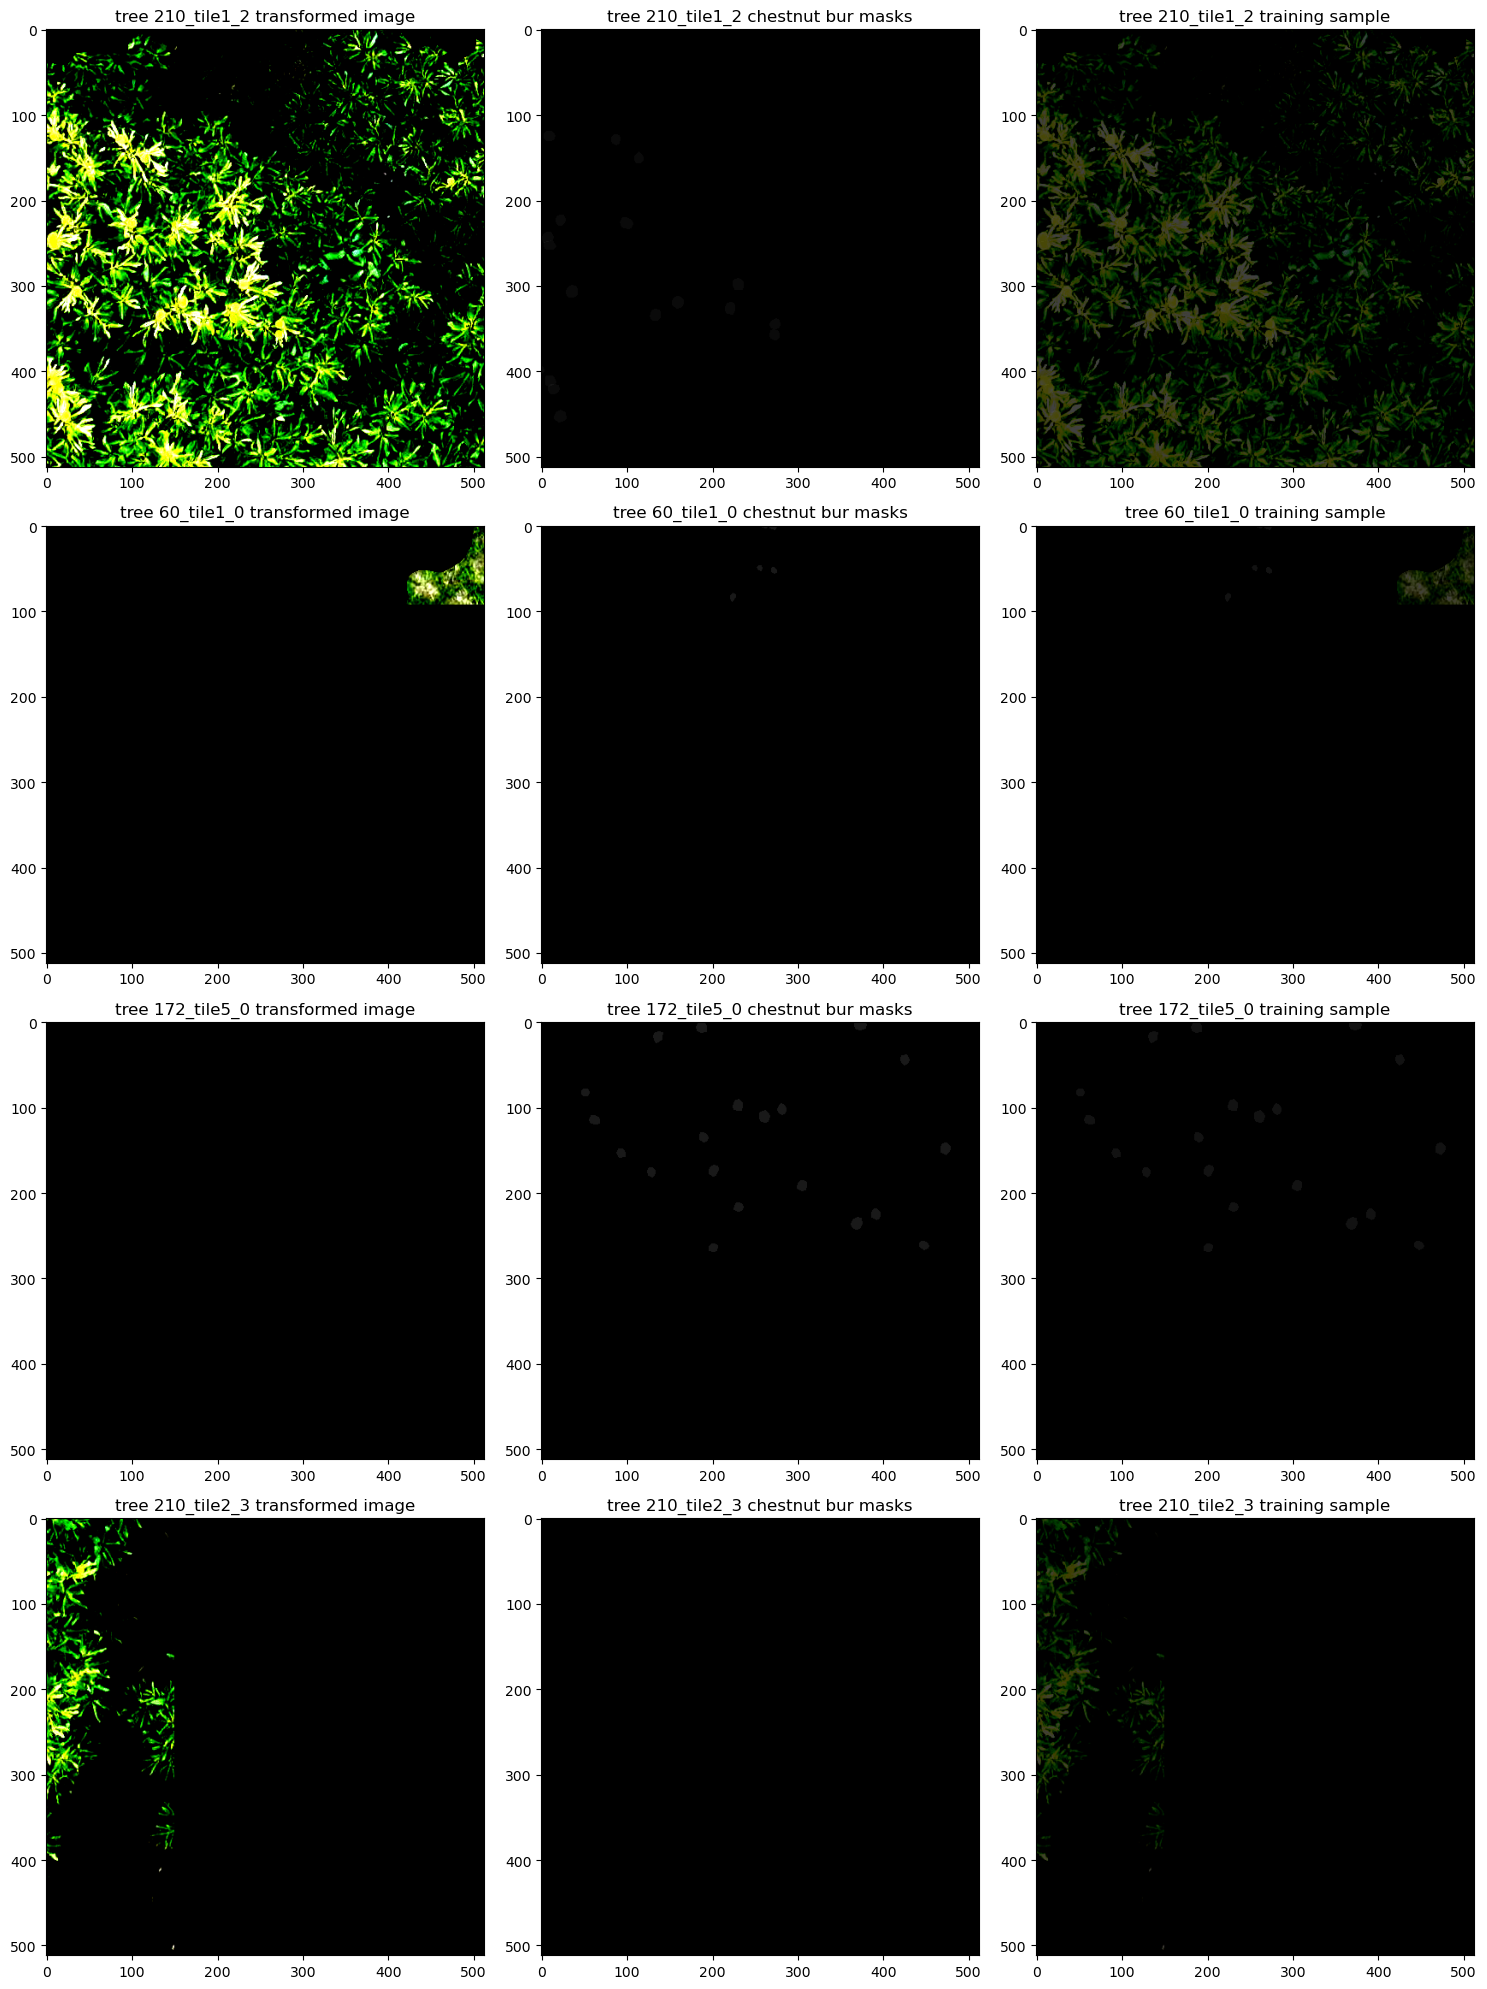

In [15]:
%matplotlib inline
tree_ids = [target["image_id"] for target in targets]

# plot image, mask, and image with mask overlay
def plot_images(images, targets, tree_ids):
    fig, ax = plt.subplots(len(images), 3, figsize=(15, 5*len(images)))
    for i, (image, target, tree_id) in enumerate(zip(images, targets, tree_ids)):
        image = image.permute(1, 2, 0)
        mask = target["masks"].permute(1, 2, 0)
        ax[i, 0].imshow(image)
        ax[i, 0].set_title(f"tree {tree_id} transformed image")
        ax[i, 1].imshow(mask.sum(axis=2), cmap="gray")
        ax[i, 1].set_title(f"tree {tree_id} chestnut bur masks")
        ax[i, 2].imshow(image)
        ax[i, 2].imshow(mask.sum(axis=2), cmap='gray', alpha=0.75)
        ax[i, 2].set_title(f"tree {tree_id} training sample")
    plt.tight_layout()
    plt.show()

plot_images(images, targets, tree_ids)

In [16]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# # save each transformed image with its canopy mask and chestnut polygon masks to a folder. Name image treeID.png

# os.makedirs("C:/Users/exx/Deep Learning/Chestnut_Bur_Instance_Segmentation/route9_orchard3/transformed_images", exist_ok=True)

# for i, (image, target) in enumerate(zip(images, targets)):

#     tree_id = target["image_id"]
#     image = image.permute(1, 2, 0)
#     mask = target["masks"].permute(1, 2, 0)

#     #plot mask on image and save to .png file
#     plt.imshow(image)
#     plt.imshow(mask.sum(axis=2), cmap='gray', alpha=0.75)
#     plt.savefig(f"C:/Users/exx/Deep Learning/Chestnut_Bur_Instance_Segmentation/route9_orchard3/transformed_images/{tree_id}_transformed.png")
#     plt.close()

##### <center> Construct MaskRCNN Model </center>

In [ ]:
def get_instance_segmentation_model(num_classes):
    # Load a Mask R-CNN instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(
        weights=torchvision.models.detection.MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT,
        weights_backbone=torchvision.models.ResNet50_Weights.DEFAULT
    )

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one to reflect the number of classes
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    # Get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    # Replace the mask predictor with a new one
    model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [ ]:
print(get_instance_segmentation_model(2))

##### <center> Tune model hyperparameters using bayesian optimization algo and hyperband scheduler </center>

##### adapted from: https://docs.ray.io/en/latest/tune/examples/bohb_example.html

In [ ]:
# Bayesian Optimization HyperBand (BOHB) with HyperBand scheduler
# # https://proceedings.mlr.press/v80/falkner18a.html

import tempfile
import time
import ray
from ray import train, tune
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB

In [ ]:
def train_ChestnutBurSegmentation(search_space, indices):
    train_ds = ray.get(search_space["train_ds_ref"])
    val_dl = ray.get(search_space["val_dl_ref"])

    model = get_instance_segmentation_model(num_classes = 2) # background, chestnut bur
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model) # train on multiple gpus if available
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, 
                                lr = search_space["lr"], 
                                momentum = search_space["momentum"], 
                                weight_decay = search_space["weight_decay"])

    warmup_factor = 1.0 / 1000
    warmup_iters = min(1000, int(len(indices)*0.8) - 1)

    # construct a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )
    
    # load existing checkpoint if available
    if train.get_checkpoint():
        loaded_checkpoint = train.get_checkpoint()
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
            model_state, optimizer_state = torch.load(
                os.path.join(loaded_checkpoint_dir, "checkpoint.pt")
            )
            model.load_state_dict(model_state)
            optimizer.load_state_dict(optimizer_state)
    else:
        start_epoch = 0

    # load data from object store references
    train_dl = DataLoader(train_ds, # first 80% of dataset for training
                           batch_size = search_space["batch_size"],
                           shuffle = True,
                           collate_fn = ChestnutBurSegmentation.collate_fn,
                           num_workers=0, 
                           pin_memory=True)

    print_freq = 2

    # Main training function
    for epoch in range(start_epoch, search_space["epochs"]):
        # train for one epoch, printing every 10 iterations
        train_logger, val_logger = engine.train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq, val_dl, scaler=None)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        train_metrics, val_metrics = engine.evaluate(model, val_dl, device, train_dl)

        # save checkpoint
         # Here we save a checkpoint. It is automatically registered with Ray Tune
        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            path = os.path.join(temp_checkpoint_dir, "checkpoint.pt")
            torch.save(
                (model.state_dict(), optimizer.state_dict()), path
            )
            checkpoint = train.Checkpoint.from_directory(temp_checkpoint_dir)
            train.report(
                {"train_loss": train_logger.loss.avg, # train loss,
                "val_loss": val_logger.loss.avg, # val loss
                "train_mAP_50": train_metrics.coco_eval['segm'].stats[1], # train mAP@50
                "val_mAP_50": val_metrics.coco_eval['segm'].stats[1], # val mAP@50
                "train_mAR_100": train_metrics.coco_eval['segm'].stats[8], # train mAR@100
                "val_mAR_100": val_metrics.coco_eval['segm'].stats[8], # val mAR@100
                "epoch": epoch}, 
                checkpoint = checkpoint
            )
    
    print("Tuning Trial Complete!")


def test_best_model(best_result, indices, image_dir, df):
    best_model = get_instance_segmentation_model(num_classes = 2) # background, chestnut bur

    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    best_model.to(device)

    checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")

    model_state, _ = torch.load(checkpoint_path)
    best_model.load_state_dict(model_state)

    test_ds = ChestnutBurSegmentation(image_dir, df, get_transform(train = False))
    test_ds = Subset(test_ds, indices[-int(len(test_ds)*0.05):]) # last 5% of dataset for testing
    test_dl = DataLoader(test_ds, batch_size = 1, shuffle = False, collate_fn = ChestnutBurSegmentation.collate_fn, num_workers=0, pin_memory=True)

    test_results = engine.evaluate(best_model, test_dl, device, train_data_loader=None)

    print(f'Best trial test set mAP_50: {test_results.coco_eval["segm"].stats[1]} and mAR_100: {test_results.coco_eval["segm"].stats[8]}')

    return test_results

def trial_dirname_creator(trial):
    return f"train_MAVdroneDataset_{trial.trial_id}"

In [ ]:
gc.collect()
torch.cuda.empty_cache()

# store indices in random order list for subsetting
indices = torch.randperm(len(sample_ds)).tolist()

def main(num_samples, indices):
    train_ds = Subset(ChestnutBurSegmentation(image_dir, 
                                                df, 
                                                get_transform(train = True)
                                                ), 
                    indices[:-int(len(indices)*0.2)] # first 80% of dataset for training
                    ) 

    val_dl = DataLoader(Subset(ChestnutBurSegmentation(image_dir, 
                                                        df, 
                                                        get_transform(train = False)
                                                        ), 
                                indices[-int(len(indices)*0.2):-int(len(indices)*0.05)] # next 15% of dataset for validation
                                ),
                        batch_size = 1,
                        shuffle = False,
                        collate_fn = ChestnutBurSegmentation.collate_fn,
                        num_workers=0,
                        pin_memory=True
                        )

    # put large objects in object store; reference in search_space
    train_ds_ref = ray.put(train_ds)
    val_dl_ref = ray.put(val_dl)

    search_space = {
        "epochs": 10,
        "lr": tune.uniform(0.00009, 0.05),
        "momentum": tune.uniform(0.00001, 0.99),
        "weight_decay": tune.uniform(0.00001, 0.99),
        "batch_size": tune.choice([2, 4, 8]),
        "train_ds_ref": train_ds_ref,
        "val_dl_ref": val_dl_ref
    }

    algo = TuneBOHB(
        metric="val_mAP_50",
        mode="max",
        points_to_evaluate=[
            {"lr": 0.005, 
             "momentum": 0.9, 
             "weight_decay": 0.0005, 
             "batch_size": 2},
        ]
    )
    algo = tune.search.ConcurrencyLimiter(algo, max_concurrent=1)
    scheduler = HyperBandForBOHB(
        time_attr="training_iteration",
        max_t=int(search_space["epochs"]),
        reduction_factor=4,
        stop_last_trials=False,
    )

    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_ChestnutBurSegmentation, indices=indices),
            resources = {"cpu": 24.0, "gpu": 1.0},
        ),
        run_config=train.RunConfig(
            name="bohb_exp",
            storage_path='C:/Users/exx/Documents/GitHub/Savanna-Institute/Drone-based_Chestnut_Detection/ray_results',
            stop={"training_iteration": int(search_space["epochs"])},
        ),
        tune_config = tune.TuneConfig(
            metric = "val_mAP_50",
            mode = "max",
            search_alg = algo,
            scheduler = scheduler,
            num_samples = int(num_samples),
            time_budget_s=600000,
            trial_dirname_creator=trial_dirname_creator
        ),
        param_space=search_space
    )

    results = tuner.fit()

    best_trial = results.get_best_result(metric = "val_mAP_50", mode = "max", scope = "all", filter_nan_and_inf=False)

    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final training loss: {}".format(best_trial.metrics["train_loss"]))
    print("Best trial final validation loss: {}".format(best_trial.metrics["val_loss"]))
    print("Best trial final training mAP_50: {}".format(best_trial.metrics["train_mAP_50"]))
    print("Best trial final validation mAP_50: {}".format(best_trial.metrics["val_mAP_50"]))
    print("Best trial final training mAR_100: {}".format(best_trial.metrics["train_mAR_100"]))
    print("Best trial final validation mAR_100: {}".format(best_trial.metrics["val_mAR_100"]))

    test_performance = test_best_model(best_trial, indices, image_dir, df)

    return best_trial, test_performance

if __name__ == "__main__": 
    best_trial = main(num_samples = 20, indices = indices)

In [ ]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2 # (background = 0, chestnut bur = 1)

train_dl = DataLoader(ray.get(best_trial.config["train_ds_ref"]), 
                      batch_size = best_trial.config["batch_size"], 
                      shuffle = True, 
                      collate_fn = ChestnutBurSegmentation.collate_fn,
                      num_workers=4,
                      pin_memory=True)

valid_dl = ray.get(best_trial.config["val_dl_ref"])

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=best_trial.config["lr"],
    momentum=best_trial.config["momentum"],
    weight_decay=best_trial.config["weight_decay"]
)

warmup_factor = 1.0 / 1000
warmup_iters = min(1000, int(len(indices)*0.8) - 1)

# construct a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer, start_factor=warmup_factor, total_iters=warmup_iters
    )

num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_logger, val_logger = engine.train_one_epoch(model, optimizer, train_dl, valid_dl, device, epoch, print_freq=2, scaler=None)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    train_performance, val_performance = engine.evaluate(model, valid_dl, device, train_dl)

print("That's it!")

In [ ]:
# save model and weights to .pth
torch.save(model.state_dict(), f"C:/Users/exx/Documents/GitHub/Savanna-Institute/Drone-based_Chestnut_Detection/MaskRCNN_{time.strftime('%Y%m%d')}_{time.strftime('%H%M%S')}.pth")